El objetivo es entrenar un algoritmo capaz de detectar transacciones fraudulentas. Las bases de datos con las que se trabaja en este tipo de proyectos suelen encontrarse desbalanceadas (un porcentaje bajoo de transacciones son fraudulentas) y ademas se desconocen varias caracteristicas por cuestiones de privacidad (el nombre de las variables se oculta). La descripsion del dataset  utilizado en este caso asegura que todas las features, con excepcion de time y amount, fueron previamente escaladas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Otras librerias
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Se carga la base de datos

df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Se realiza un primer analasis rapido de los datos

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
#Se busca la cantindad de valores nulos

df.isnull().sum().max()

0

In [5]:
#Se muestra la cantidad de informacion con la que cuenta cada columna

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
#Se busca que porcentaje del total representan las transaciones fraudulentas y no fraudulentas

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


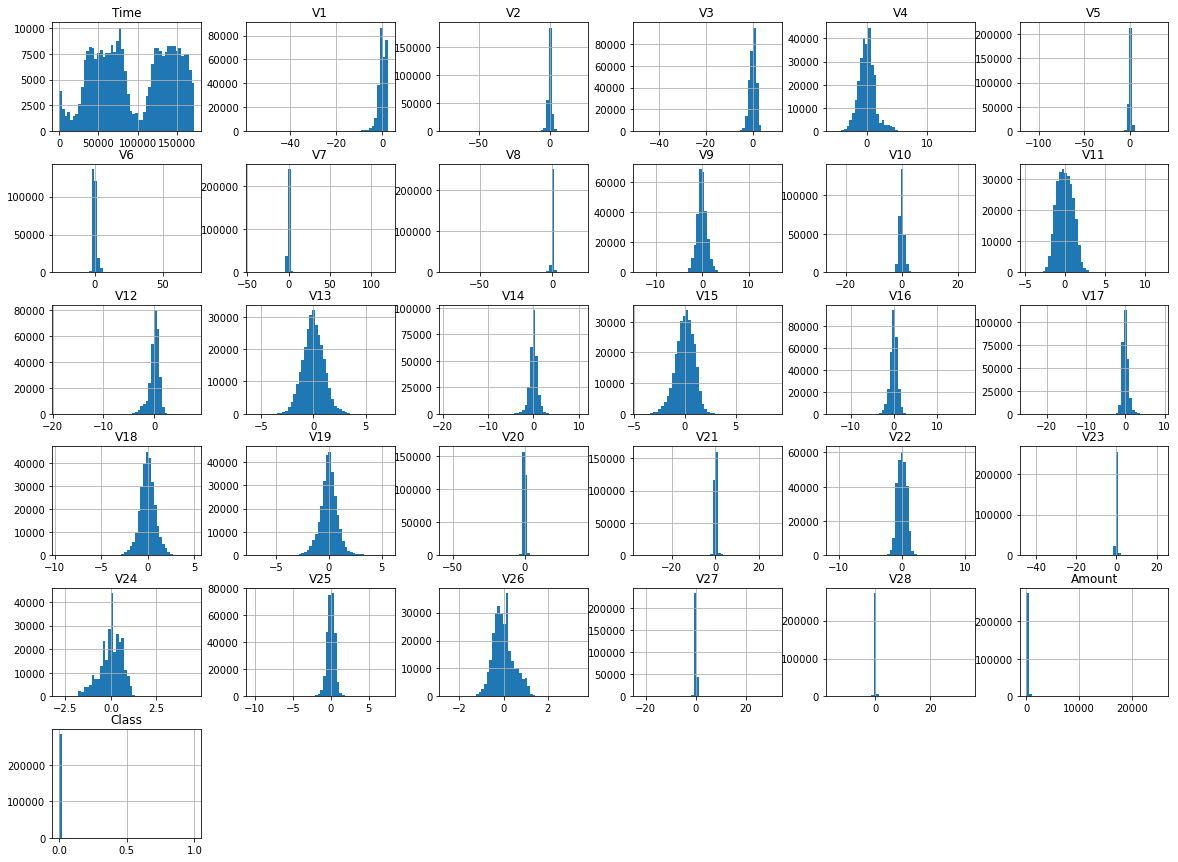

In [7]:
#Se grafican los histogramas de cada feature para visualizar su distribucion

df.hist(bins=50, figsize=(20,15))
plt.show()

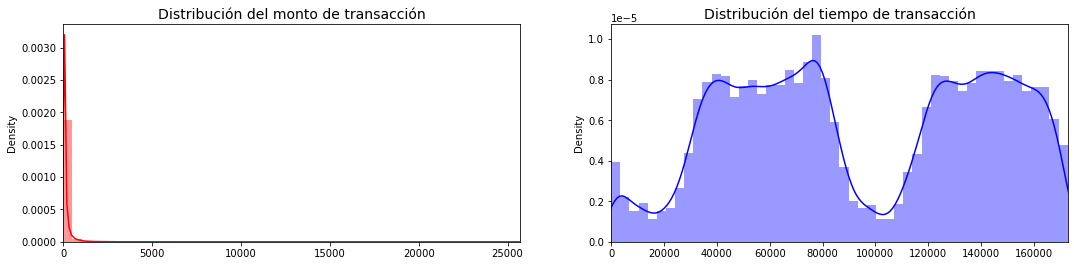

In [8]:
#Se muestran los graficos de densidad para Time y Amount

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribución del monto de transacción', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribución del tiempo de transacción', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

De este analisis preliminar se puede determinar que solo un porcentaje muy chico de transaciones supera un monto de 1000

In [9]:
print('El monto menor a 1000 equivale al', round((df['Amount']>1000).value_counts()[0]/len(df) * 100,2), '% del dataset')
print('El monto mayor a 1000 equivale al', round((df['Amount']>1000).value_counts()[1]/len(df) * 100,2), '% del dataset')

print('El monto menor a 20000 equivale al', round((df['Amount']>20000).value_counts()[0]/len(df) * 100,4), '% del dataset')
print('El monto mayor a 20000 equivale al', round((df['Amount']>20000).value_counts()[1]/len(df) * 100,4), '% del dataset')

El monto menor a 1000 equivale al 98.97 % del dataset
El monto mayor a 1000 equivale al 1.03 % del dataset
El monto menor a 20000 equivale al 99.9996 % del dataset
El monto mayor a 20000 equivale al 0.0004 % del dataset


Se pueden aplicar dos estrategias para equilibrar el desbalance de la base de datos. Una de estas crear una submuestra con relacion 50:50 de casos de fraude y no fraude por remocion aleatoria de casos no fraudulentos. El uso de la base original provocaria en primer lugar un sobreajuste, el modelo de clasificación supondria que en la mayoría de los casos no hay fraudes, pero se debe procurar que el modelo detecta cuándo ocurre un fraude, y en segundo lugar correlaciones incorrectas, aunque se desconoce el significado de las características "V", es útil comprender cómo cada una de estas características influye en el resultado, pero al tener un marco de datos desequilibrados no es posible determinar las verdaderas correlaciones entre la clase y las características.
Otra estrategia para resolver este problema es aplicar la tecnica SMOTE que crea puntos sintéticos de la clase minoritaria para alcanzar un equilibrio equitativo entre ambas clases. Para ubicar los puntos sintéticos, SMOTE elige la distancia entre los vecinos más cercanos de la clase minoritaria, entre estas distancias crea puntos sintéticos. El efecto final es que se conserva más información ya que no tuvimos que eliminar ninguna fila a diferencia del submuestreo aleatorio. Aunque es probable que SMOTE sea más preciso que el submuestreo aleatorio, lleva más tiempo entrenar ya que no se eliminan filas.

In [10]:
# Se escalan las ultimas columnas que faltan ser escaladas (Amount y Time)

# RobustScaler es menos propenso a outliers
#std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
#Se mueven las columnas de amount y time para adelante

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Antes de continuar con las técnicas de submuestreo aleatorio y SMOTE, hay que separar el marco de datos original. El objetivo es ajustar el modelo con los marcos de datos que fueron submuestreados y sobremuestreados (para que el modelo detecte los patrones) y testearlo en el conjunto de prueba original.

In [12]:
#Se crean dos dataframes para separar las variables X e y 

X = df.drop('Class', axis=1)
y = df['Class']

#Se generan sets de entrenamiento y testeo manteniendo la proporcion de clases 

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Se convierten los sets en array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#Se evalua si la proporcion de clases se mantiene para los sets de entrenamiento y testeo

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Para implementar Random Under Sampling se debe determinar cuántas instancias se consideran transacciones fraudulentas (Fraud = "1") y luego se deben llevar las transacciones no fraudulentas a la misma cantidad que las transacciones fraudulentas. El siguiente paso consiste en mezclar los datos para mantener la precision del modelo.

In [13]:
#Se cuentan la cantidad de instancias de cada clase

vc = df['Class'] == 1
vc.value_counts()

False    284315
True        492
Name: Class, dtype: int64

In [14]:
#Se mezclan los datos

df = df.sample(frac=1)

#Se crea un dataframe con los 492 casos fraudulentos y otro con los primeros 492 casos no fruadulentos post-mezclado

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

#Se crea un dataframe por concatenacion de ambos df

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Mezclo el dataframe
RUS_df = normal_distributed_df.sample(frac=1, random_state=42)

RUS_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
94301,-0.167819,-0.233426,1.211593,0.052983,0.967174,1.133970,-0.445215,0.307697,-0.475174,0.058328,...,-0.010773,-0.099936,-0.005092,-0.126910,-0.416978,0.576641,-0.361675,0.081079,0.033012,0
88258,-0.214910,-0.265898,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,...,0.290187,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,1
175642,1.590163,0.443321,-0.955250,-0.077147,1.872427,-1.701269,-0.402581,0.193630,0.664402,0.076683,...,-0.146482,-0.491652,-1.232010,0.107713,-0.397827,0.282076,-0.029379,-0.026628,0.060468,0
30473,-0.105359,-0.572728,-4.194074,4.382897,-5.118363,4.455230,-4.812621,-1.224645,-7.281328,3.332250,...,0.579098,1.550473,0.614573,0.028521,0.013704,-0.149512,-0.131687,0.473934,0.473757,1
17480,1.089779,-0.657162,-30.552380,16.713389,-31.103685,6.534984,-22.105532,-4.977692,-20.371514,20.007208,...,1.733644,1.816520,-2.288686,-1.460544,0.183179,2.208209,-0.208824,1.232636,0.356660,1


In [15]:
#Se aplica la tecnica SMOTE

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

SM_df = X_sm.join(y_sm, lsuffix='_caller', rsuffix='_other')
SM_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [16]:
#Se cuentan la cantidad de instancias de cada clase tras haber aplicado RUS y SMOTE

RUS_vc = RUS_df['Class'] == 1
RUS_vc.value_counts()

False    492
True     492
Name: Class, dtype: int64

In [17]:
SM_vc = SM_df['Class'] == 1
SM_vc.value_counts()

False    284315
True     284315
Name: Class, dtype: int64

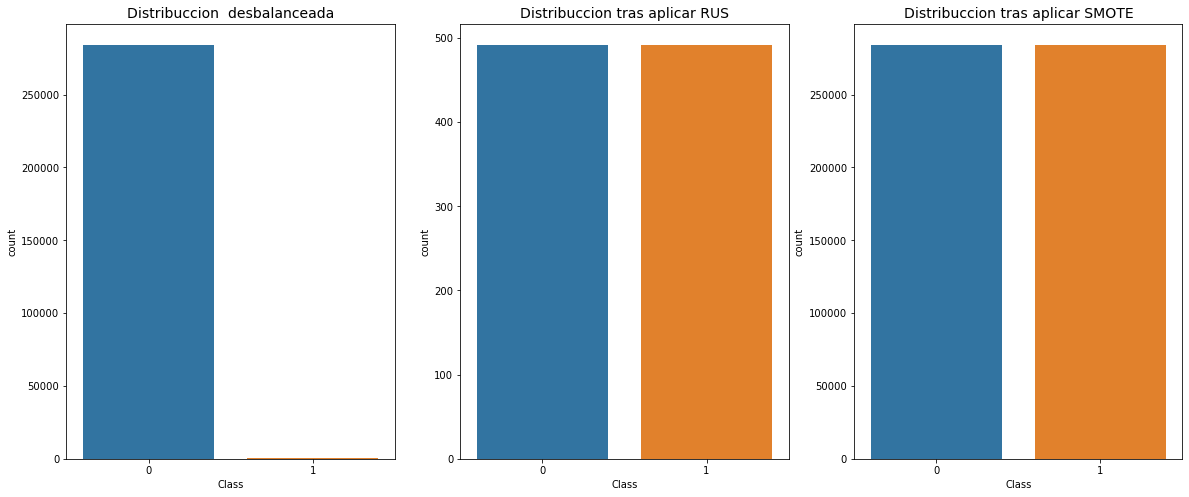

In [18]:
#Se sigue con el analisis de las bases de datos balanceada

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

sns.countplot('Class', data=df, ax= ax1)
ax1.set_title("Distribuccion  desbalanceada", fontsize=14)

sns.countplot('Class', data=RUS_df, ax=ax2)
ax2.set_title("Distribuccion tras aplicar RUS", fontsize=14)

sns.countplot('Class', data=SM_df, ax=ax3)
ax3.set_title("Distribuccion tras aplicar SMOTE", fontsize=14)

plt.show()

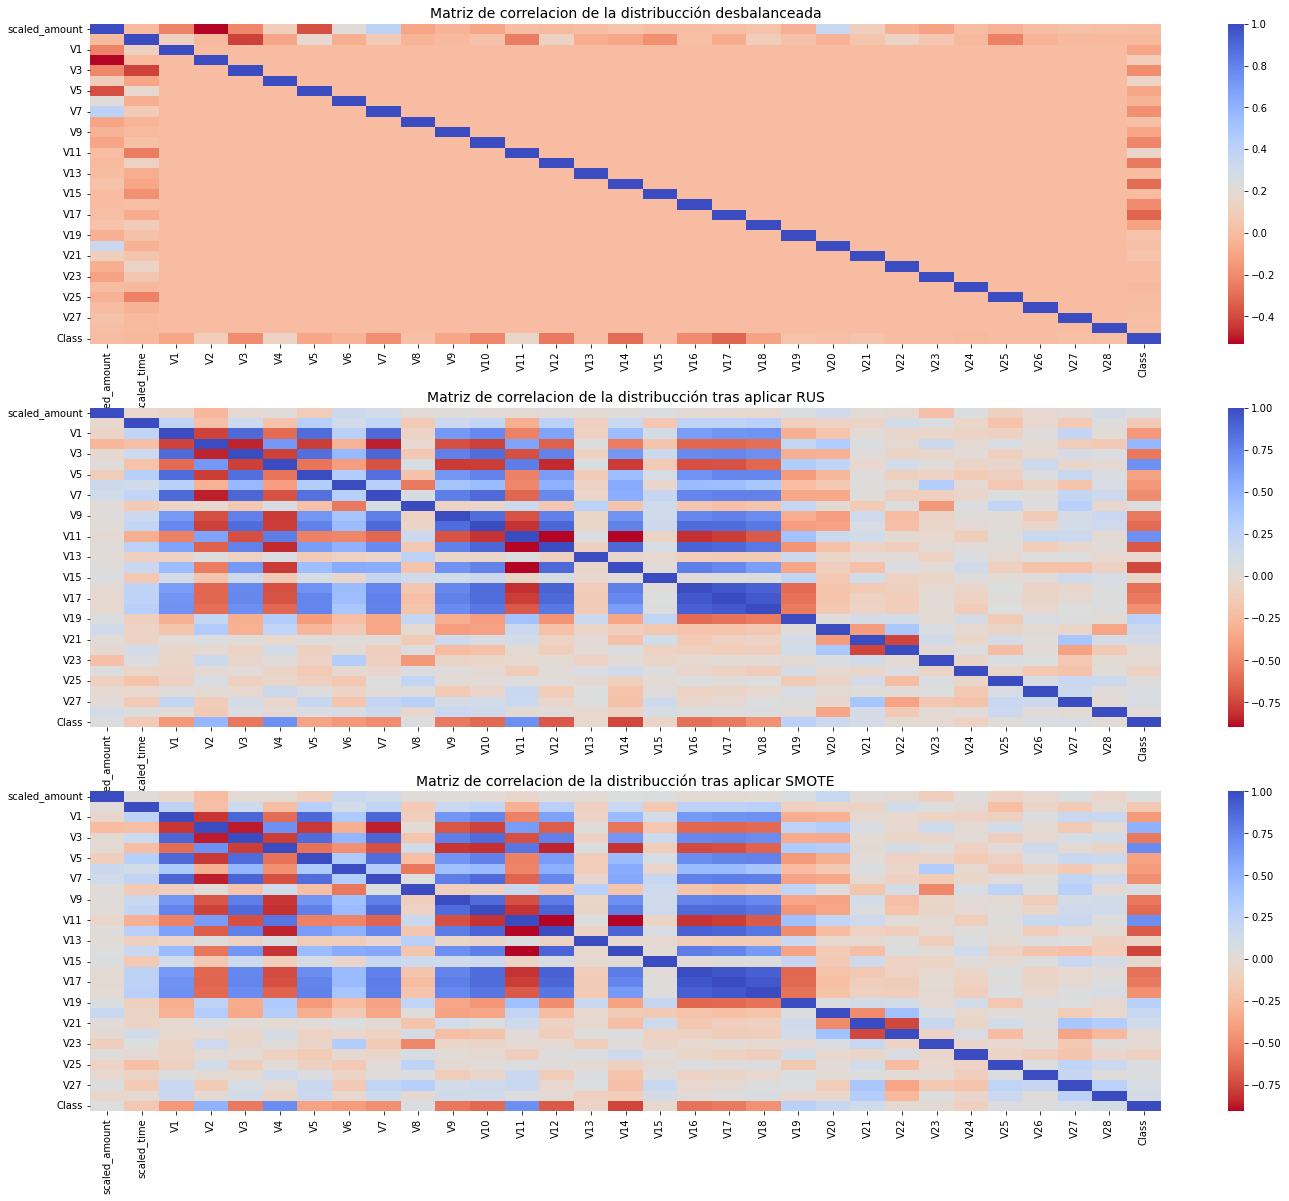

In [19]:
#Se evaluan la correlacion entre las caracteristicas

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matriz de correlacion de la distribucción desbalanceada", fontsize=14)

RUS_corr = RUS_df.corr()
sns.heatmap(RUS_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Matriz de correlacion de la distribucción tras aplicar RUS", fontsize=14)

SM_corr = SM_df.corr()
sns.heatmap(SM_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax3)
ax3.set_title("Matriz de correlacion de la distribucción tras aplicar SMOTE", fontsize=14)


plt.show()

Se muestra el heatmap de la distribucion desbalanceada con fines ilustrativos. Si se evaluan las correlaciones entre las caracteristicas V y la clase se obtiene que V17, V14, V12 y V10 están correlacionadas negativamente, mientras que V2, V4, V11 y V19 están correlacionadas positivamente. Se pueden utilizar boxplots para comprender mejor la distribución de estas características en transacciones fradulentas y no fradulentas.

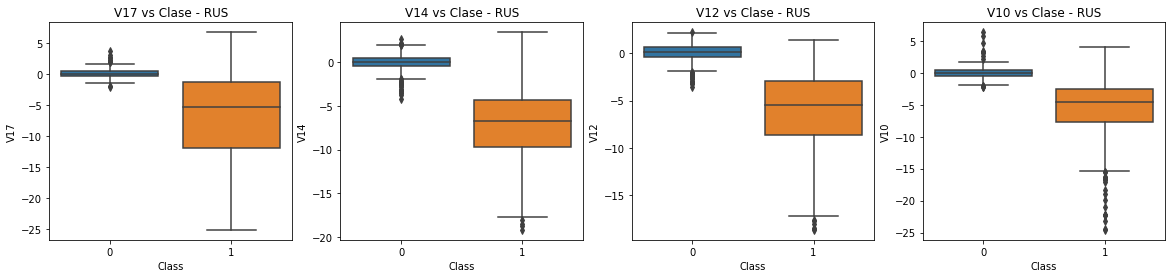

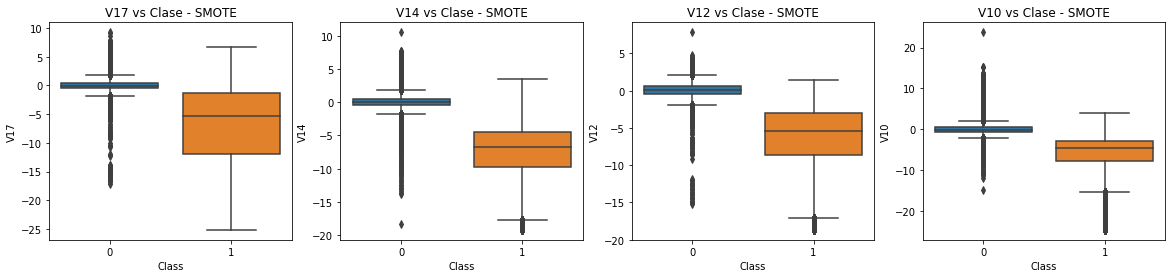

In [20]:
#Correlacione negativas

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=RUS_df, ax=axes[0])
axes[0].set_title('V17 vs Clase - RUS')

sns.boxplot(x="Class", y="V14", data=RUS_df, ax=axes[1])
axes[1].set_title('V14 vs Clase - RUS')


sns.boxplot(x="Class", y="V12", data=RUS_df, ax=axes[2])
axes[2].set_title('V12 vs Clase - RUS')


sns.boxplot(x="Class", y="V10", data=RUS_df, ax=axes[3])
axes[3].set_title('V10 vs Clase - RUS')

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=SM_df, ax=axes[0])
axes[0].set_title('V17 vs Clase - SMOTE')

sns.boxplot(x="Class", y="V14", data=SM_df, ax=axes[1])
axes[1].set_title('V14 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V12", data=SM_df, ax=axes[2])
axes[2].set_title('V12 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V10", data=SM_df, ax=axes[3])
axes[3].set_title('V10 vs Clase - SMOTE')

plt.show()

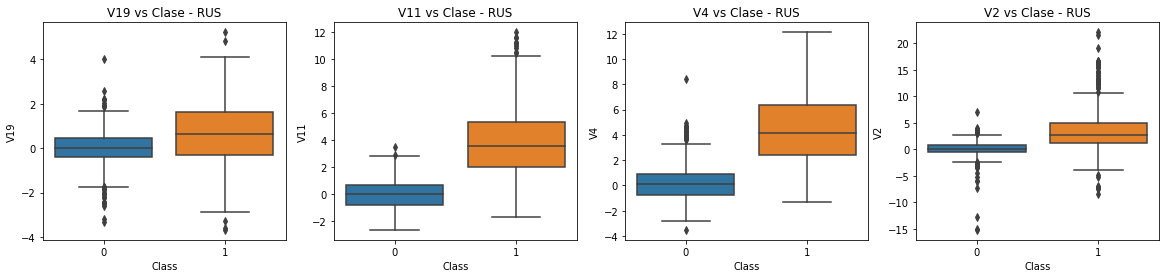

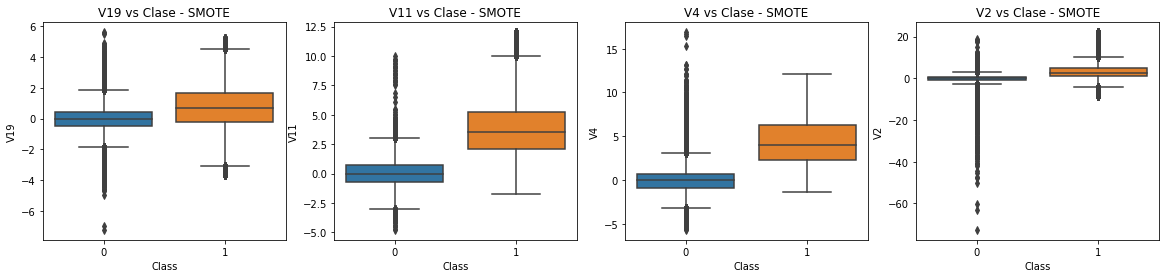

In [21]:
#Correlaciones positivas

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V19", data=RUS_df, ax=axes[0])
axes[0].set_title('V19 vs Clase - RUS')

sns.boxplot(x="Class", y="V11", data=RUS_df, ax=axes[1])
axes[1].set_title('V11 vs Clase - RUS')


sns.boxplot(x="Class", y="V4", data=RUS_df, ax=axes[2])
axes[2].set_title('V4 vs Clase - RUS')


sns.boxplot(x="Class", y="V2", data=RUS_df, ax=axes[3])
axes[3].set_title('V2 vs Clase - RUS')

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V19", data=SM_df, ax=axes[0])
axes[0].set_title('V19 vs Clase - SMOTE')

sns.boxplot(x="Class", y="V11", data=SM_df, ax=axes[1])
axes[1].set_title('V11 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V4", data=SM_df, ax=axes[2])
axes[2].set_title('V4 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V2", data=SM_df, ax=axes[3])
axes[3].set_title('V2 vs Clase - SMOTE')

plt.show()

Se busca eliminar los outliers de las características que tienen una alta correlación con la clase.Esto tiene un impacto positivo en la precisión de los modelos. Se aplica el método de rango intercuartíl. El objetivo es crear un umbral más allá del percentil 75 y 25 para que, en caso de que alguna instancia pase este umbral, la instancia sea eliminada.El umbral se determina multiplicando un número (por ejemplo: 1,5) por el rango intercuartíl. Cuanto más alto sea este umbral, detectara menos valores atípicos. Si el umbra es demasiado bajo, se podría correr el riesgo de perdér información, lo que hará que los modelos tengan una precisión menor.

In [22]:
#Se eliminan outliers de caracteristicas bien correlaccionadas con la clase, en casos frudulentos y distribucion RUS

#Se remueven los outliers de V14
RUS_v14_fraud = RUS_df['V14'].loc[RUS_df['Class'] == 1].values
RUS_q25, RUS_q75 = np.percentile(RUS_v14_fraud, 25), np.percentile(RUS_v14_fraud, 75)
#print('RUS cuartil 25: {} | RUS cuartil 75: {}'.format(RUS_q25, RUS_q75))
RUS_v14_iqr = RUS_q75 - RUS_q25
#print('RUS IQR: {}'.format(RUS_v14_iqr))

RUS_v14_cut_off = RUS_v14_iqr * 1.5
RUS_v14_lower, RUS_v14_upper = RUS_q25 - RUS_v14_cut_off, RUS_q75 + RUS_v14_cut_off
#print('RUS Umbral: {}'.format(RUS_v14_cut_off))
print('RUS V14 minimo: {}'.format(RUS_v14_lower))
print('RUS V14 maximo: {}'.format(RUS_v14_upper))

outliers = [x for x in RUS_v14_fraud if x < RUS_v14_lower or x > RUS_v14_upper]
print('V14 outliers:{}'.format(outliers))
print('Caracteristica V14 outliers para casos fraudulentos: {}'.format(len(outliers)))

RUS_df = RUS_df.drop(RUS_df[(RUS_df['V14'] > RUS_v14_upper) | (RUS_df['V14'] < RUS_v14_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V14: {}'.format(len(RUS_df)))
print('----' * 30)

#Se remueven los outliers de V12
RUS_v12_fraud = RUS_df['V12'].loc[RUS_df['Class'] == 1].values
RUS_q25, RUS_q75 = np.percentile(RUS_v12_fraud, 25), np.percentile(RUS_v12_fraud, 75)
RUS_v12_iqr = RUS_q75 - RUS_q25

RUS_v12_cut_off = RUS_v12_iqr * 1.5
RUS_v12_lower, RUS_v12_upper = RUS_q25 - RUS_v12_cut_off, RUS_q75 + RUS_v12_cut_off
print('V12 minimo: {}'.format(RUS_v12_lower))
print('V12 maximo: {}'.format(RUS_v12_upper))
outliers = [x for x in RUS_v12_fraud if x < RUS_v12_lower or x > RUS_v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Caracteristica V12 Outliers para casos fraudulentos: {}'.format(len(outliers)))
RUS_df = RUS_df.drop(RUS_df[(RUS_df['V12'] > RUS_v12_upper) | (RUS_df['V12'] < RUS_v12_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V12: {}'.format(len(RUS_df)))
print('----' * 30)

"""
Si se remueven los outliers de V10, se pierde demasiada informacion
RUS_v10_fraud = RUS_df['V10'].loc[RUS_df['Class'] == 1].values
RUS_q25, RUS_q75 = np.percentile(RUS_v10_fraud, 25), np.percentile(RUS_v10_fraud, 75)
RUS_v10_iqr = RUS_q75 - RUS_q25

RUS_v10_cut_off = RUS_v10_iqr * 1.5
RUS_v10_lower, RUS_v10_upper = RUS_q25 - RUS_v10_cut_off, RUS_q75 + RUS_v10_cut_off
print('V10 minimo: {}'.format(RUS_v10_lower))
print('V10 maximo: {}'.format(RUS_v10_upper))
outliers = [x for x in RUS_v10_fraud if x < RUS_v10_lower or x > RUS_v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Caracteristica V10 Outliers para casos fraudulentos: {}'.format(len(outliers)))
RUS_df = RUS_df.drop(RUS_df[(RUS_df['V10'] > RUS_v10_upper) | (RUS_df['V10'] < RUS_v10_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V10: {}'.format(len(RUS_df)))
print('----' * 30)
"""

#Se remueven los outliers de V19
RUS_v19_fraud = RUS_df['V19'].loc[RUS_df['Class'] == 1].values
RUS_q25, RUS_q75 = np.percentile(RUS_v19_fraud, 25), np.percentile(RUS_v19_fraud, 75)
RUS_v19_iqr = RUS_q75 - RUS_q25

RUS_v19_cut_off = RUS_v19_iqr * 1.5
RUS_v19_lower, RUS_v19_upper = RUS_q25 - RUS_v19_cut_off, RUS_q75 + RUS_v19_cut_off
print('V19 minimo: {}'.format(RUS_v19_lower))
print('V19 maximo: {}'.format(RUS_v19_upper))
outliers = [x for x in RUS_v19_fraud if x < RUS_v19_lower or x > RUS_v19_upper]
print('V19 outliers: {}'.format(outliers))
print('Caracteristica V19 Outliers para casos fraudulentos: {}'.format(len(outliers)))
RUS_df = RUS_df.drop(RUS_df[(RUS_df['V19'] > RUS_v19_upper) | (RUS_df['V19'] < RUS_v19_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V19: {}'.format(len(RUS_df)))
print('----' * 30)

"""
Si se remueven los outliers de V10, se pierde demasiada informacion
RUS_v11_fraud = RUS_df['V11'].loc[RUS_df['Class'] == 1].values
RUS_q25, RUS_q75 = np.percentile(RUS_v11_fraud, 25), np.percentile(RUS_v11_fraud, 75)
RUS_v11_iqr = RUS_q75 - RUS_q25

RUS_v11_cut_off = RUS_v11_iqr * 1.5
RUS_v11_lower, RUS_v11_upper = RUS_q25 - RUS_v11_cut_off, RUS_q75 + RUS_v11_cut_off
print('V11 minimo: {}'.format(RUS_v11_lower))
print('V11 maximo: {}'.format(RUS_v11_upper))
outliers = [x for x in RUS_v11_fraud if x < RUS_v11_lower or x > RUS_v11_upper]
print('V11 outliers: {}'.format(outliers))
print('Caracteristica V11 Outliers para casos fraudulentos: {}'.format(len(outliers)))
RUS_df = RUS_df.drop(RUS_df[(RUS_df['V11'] > RUS_v11_upper) | (RUS_df['V11'] < RUS_v11_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V11: {}'.format(len(RUS_df)))
print('----' * 30)
"""

RUS V14 minimo: -17.807576138200666
RUS V14 maximo: 3.8320323237414167
V14 outliers:[-18.0499976898594, -18.8220867423816, -19.2143254902614, -18.4937733551053]
Caracteristica V14 outliers para casos fraudulentos: 4
Numero de instancia tras la remoccion de outliers de V14: 980
------------------------------------------------------------------------------------------------------------------------
V12 minimo: -17.3430371579634
V12 maximo: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.4311310279993, -18.0475965708216, -18.6837146333443]
Caracteristica V12 Outliers para casos fraudulentos: 4
Numero de instancia tras la remoccion de outliers de V12: 976
------------------------------------------------------------------------------------------------------------------------
V19 minimo: -3.1579398083338797
V19 maximo: 4.484080927387752
V19 outliers: [-3.28615008214787, 4.85125513655685, -3.68190355226504, 5.2283417900513, -3.60265725092653]
Caracteristica V19 Outliers para casos frau

"\nSi se remueven los outliers de V10, se pierde demasiada informacion\nRUS_v11_fraud = RUS_df['V11'].loc[RUS_df['Class'] == 1].values\nRUS_q25, RUS_q75 = np.percentile(RUS_v11_fraud, 25), np.percentile(RUS_v11_fraud, 75)\nRUS_v11_iqr = RUS_q75 - RUS_q25\n\nRUS_v11_cut_off = RUS_v11_iqr * 1.5\nRUS_v11_lower, RUS_v11_upper = RUS_q25 - RUS_v11_cut_off, RUS_q75 + RUS_v11_cut_off\nprint('V11 minimo: {}'.format(RUS_v11_lower))\nprint('V11 maximo: {}'.format(RUS_v11_upper))\noutliers = [x for x in RUS_v11_fraud if x < RUS_v11_lower or x > RUS_v11_upper]\nprint('V11 outliers: {}'.format(outliers))\nprint('Caracteristica V11 Outliers para casos fraudulentos: {}'.format(len(outliers)))\nRUS_df = RUS_df.drop(RUS_df[(RUS_df['V11'] > RUS_v11_upper) | (RUS_df['V11'] < RUS_v11_lower)].index)\nprint('Numero de instancia tras la remoccion de outliers de V11: {}'.format(len(RUS_df)))\nprint('----' * 30)\n"

In [23]:
#Se repite el procedimiento, pero con la distribucion SMOTE

#Se remueven los outliers de V14
SM_v14_fraud = SM_df['V14'].loc[SM_df['Class'] == 1].values
SM_q25, SM_q75 = np.percentile(SM_v14_fraud, 25), np.percentile(SM_v14_fraud, 75)
#print('SM cuartil 25: {} | SM cuartil 75: {}'.format(SM_q25, SM_q75))
SM_v14_iqr = SM_q75 - SM_q25
#print('SM IQR: {}'.format(SM_v14_iqr))

SM_v14_cut_off = SM_v14_iqr * 1.5
SM_v14_lower, SM_v14_upper = SM_q25 - SM_v14_cut_off, SM_q75 + SM_v14_cut_off
#print('SM Umbral: {}'.format(SM_v14_cut_off))
print('SM V14 minimo: {}'.format(SM_v14_lower))
print('SM V14 maximo: {}'.format(SM_v14_upper))

outliers = [x for x in SM_v14_fraud if x < SM_v14_lower or x > SM_v14_upper]
#print('V14 outliers:{}'.format(outliers))
print('Caracteristica V14 outliers para casos fraudulentos: {}'.format(len(outliers)))

SM_df = SM_df.drop(SM_df[(SM_df['V14'] > SM_v14_upper) | (SM_df['V14'] < SM_v14_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V14: {}'.format(len(SM_df)))
print('----' * 30)

#Se remueven los outliers de V12
SM_v12_fraud = SM_df['V12'].loc[SM_df['Class'] == 1].values
SM_q25, SM_q75 = np.percentile(SM_v12_fraud, 25), np.percentile(SM_v12_fraud, 75)
SM_v12_iqr = SM_q75 - SM_q25

SM_v12_cut_off = SM_v12_iqr * 1.5
SM_v12_lower, SM_v12_upper = SM_q25 - SM_v12_cut_off, SM_q75 + SM_v12_cut_off
print('V12 minimo: {}'.format(SM_v12_lower))
print('V12 maximo: {}'.format(SM_v12_upper))
outliers = [x for x in SM_v12_fraud if x < SM_v12_lower or x > SM_v12_upper]
#print('V12 outliers: {}'.format(outliers))
print('Caracteristica V12 Outliers para casos fraudulentos: {}'.format(len(outliers)))
SM_df = SM_df.drop(SM_df[(SM_df['V12'] > SM_v12_upper) | (SM_df['V12'] < SM_v12_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V12: {}'.format(len(SM_df)))
print('----' * 30)

"""
Si se remueven los outliers de V10 se pierde demasiada informacion
SM_v10_fraud = SM_df['V10'].loc[SM_df['Class'] == 1].values
SM_q25, SM_q75 = np.percentile(SM_v10_fraud, 25), np.percentile(SM_v10_fraud, 75)
SM_v10_iqr = SM_q75 - SM_q25

SM_v10_cut_off = SM_v10_iqr * 1.5
SM_v10_lower, SM_v10_upper = SM_q25 - SM_v10_cut_off, SM_q75 + SM_v10_cut_off
print('V10 minimo: {}'.format(SM_v10_lower))
print('V10 maximo: {}'.format(SM_v10_upper))
outliers = [x for x in SM_v10_fraud if x < SM_v10_lower or x > SM_v10_upper]
#print('V10 outliers: {}'.format(outliers))
print('Caracteristica V10 Outliers para casos fraudulentos: {}'.format(len(outliers)))
SM_df = SM_df.drop(SM_df[(SM_df['V10'] > SM_v10_upper) | (SM_df['V10'] < SM_v10_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V10: {}'.format(len(SM_df)))
print('----' * 30)
"""

#Se remueven los outliers de V19
SM_v19_fraud = SM_df['V19'].loc[SM_df['Class'] == 1].values
SM_q25, SM_q75 = np.percentile(SM_v19_fraud, 25), np.percentile(SM_v19_fraud, 75)
SM_v19_iqr = SM_q75 - SM_q25

SM_v19_cut_off = SM_v19_iqr * 1.5
SM_v19_lower, SM_v19_upper = SM_q25 - SM_v19_cut_off, SM_q75 + SM_v19_cut_off
print('V19 minimo: {}'.format(SM_v19_lower))
print('V19 maximo: {}'.format(SM_v19_upper))
outliers = [x for x in SM_v19_fraud if x < SM_v19_lower or x > SM_v19_upper]
#print('V19 outliers: {}'.format(outliers))
print('Caracteristica V19 Outliers para casos fraudulentos: {}'.format(len(outliers)))
SM_df = SM_df.drop(SM_df[(SM_df['V19'] > SM_v19_upper) | (SM_df['V19'] < SM_v19_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V19: {}'.format(len(SM_df)))
print('----' * 30)

"""
Si se remueven os outliers de V11 se pierde demasiada informacion
SM_v11_fraud = SM_df['V11'].loc[SM_df['Class'] == 1].values
SM_q25, SM_q75 = np.percentile(SM_v11_fraud, 25), np.percentile(SM_v11_fraud, 75)
SM_v11_iqr = SM_q75 - SM_q25

SM_v11_cut_off = SM_v11_iqr * 1.5
SM_v11_lower, SM_v11_upper = SM_q25 - SM_v11_cut_off, SM_q75 + SM_v11_cut_off
print('V11 minimo: {}'.format(SM_v11_lower))
print('V11 maximo: {}'.format(SM_v11_upper))
outliers = [x for x in SM_v11_fraud if x < SM_v11_lower or x > SM_v11_upper]
#print('V11 outliers: {}'.format(outliers))
print('Caracteristica V11 Outliers para casos fraudulentos: {}'.format(len(outliers)))
SM_df = SM_df.drop(SM_df[(SM_df['V11'] > SM_v11_upper) | (SM_df['V11'] < SM_v11_lower)].index)
print('Numero de instancia tras la remoccion de outliers de V11: {}'.format(len(SM_df)))
print('----' * 30)
"""

SM V14 minimo: -17.656373559728898
SM V14 maximo: 3.5164519796383242
Caracteristica V14 outliers para casos fraudulentos: 3179
Numero de instancia tras la remoccion de outliers de V14: 565066
------------------------------------------------------------------------------------------------------------------------
V12 minimo: -16.954969442706876
V12 maximo: 5.345200984734391
Caracteristica V12 Outliers para casos fraudulentos: 3753
Numero de instancia tras la remoccion de outliers de V12: 561313
------------------------------------------------------------------------------------------------------------------------
V19 minimo: -3.0722733593021188
V19 maximo: 4.441307992825269
Caracteristica V19 Outliers para casos fraudulentos: 2287
Numero de instancia tras la remoccion de outliers de V19: 558799
------------------------------------------------------------------------------------------------------------------------


"\nSi se remueven os outliers de V11 se pierde demasiada informacion\nSM_v11_fraud = SM_df['V11'].loc[SM_df['Class'] == 1].values\nSM_q25, SM_q75 = np.percentile(SM_v11_fraud, 25), np.percentile(SM_v11_fraud, 75)\nSM_v11_iqr = SM_q75 - SM_q25\n\nSM_v11_cut_off = SM_v11_iqr * 1.5\nSM_v11_lower, SM_v11_upper = SM_q25 - SM_v11_cut_off, SM_q75 + SM_v11_cut_off\nprint('V11 minimo: {}'.format(SM_v11_lower))\nprint('V11 maximo: {}'.format(SM_v11_upper))\noutliers = [x for x in SM_v11_fraud if x < SM_v11_lower or x > SM_v11_upper]\n#print('V11 outliers: {}'.format(outliers))\nprint('Caracteristica V11 Outliers para casos fraudulentos: {}'.format(len(outliers)))\nSM_df = SM_df.drop(SM_df[(SM_df['V11'] > SM_v11_upper) | (SM_df['V11'] < SM_v11_lower)].index)\nprint('Numero de instancia tras la remoccion de outliers de V11: {}'.format(len(SM_df)))\nprint('----' * 30)\n"

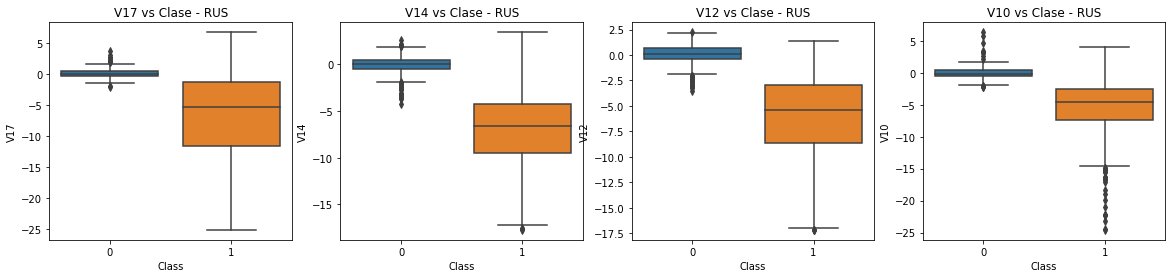

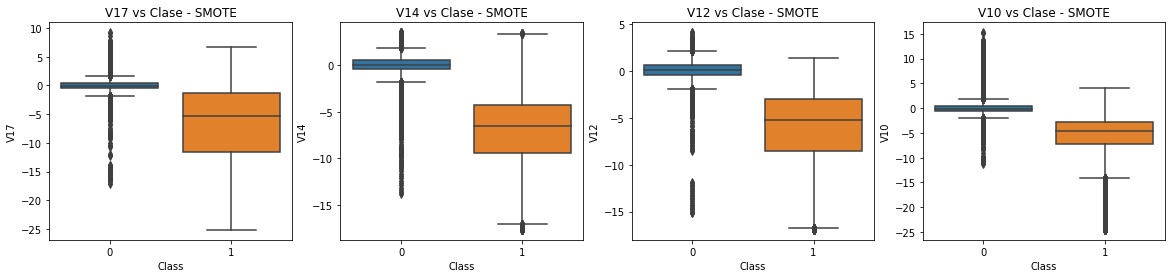

In [24]:
#Correlaciones negativas tras la remocion de outliers

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=RUS_df, ax=axes[0])
axes[0].set_title('V17 vs Clase - RUS')

sns.boxplot(x="Class", y="V14", data=RUS_df, ax=axes[1])
axes[1].set_title('V14 vs Clase - RUS')


sns.boxplot(x="Class", y="V12", data=RUS_df, ax=axes[2])
axes[2].set_title('V12 vs Clase - RUS')


sns.boxplot(x="Class", y="V10", data=RUS_df, ax=axes[3])
axes[3].set_title('V10 vs Clase - RUS')

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=SM_df, ax=axes[0])
axes[0].set_title('V17 vs Clase - SMOTE')

sns.boxplot(x="Class", y="V14", data=SM_df, ax=axes[1])
axes[1].set_title('V14 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V12", data=SM_df, ax=axes[2])
axes[2].set_title('V12 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V10", data=SM_df, ax=axes[3])
axes[3].set_title('V10 vs Clase - SMOTE')

plt.show()

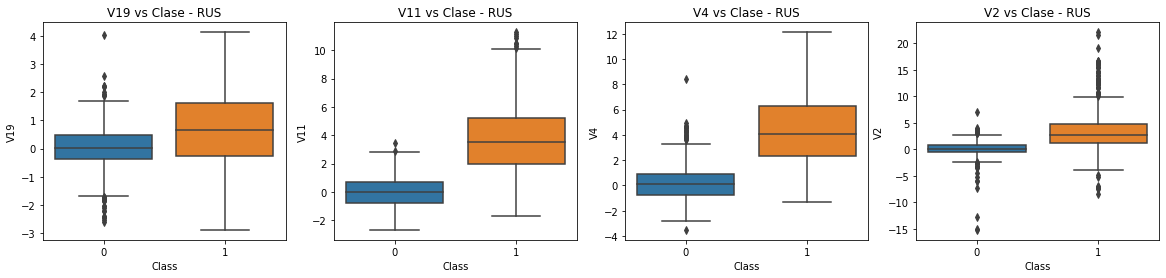

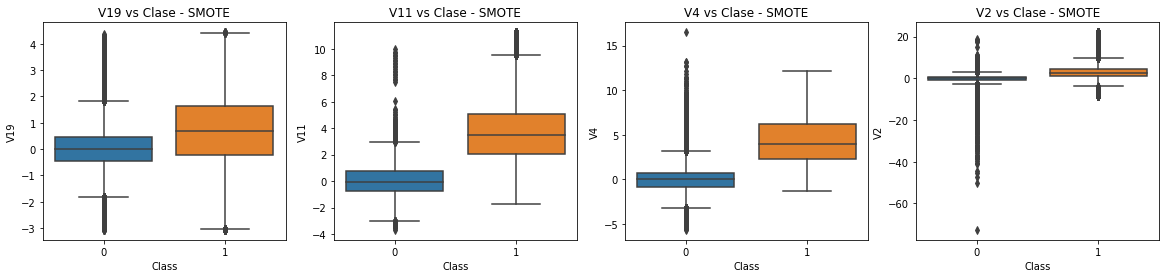

In [25]:
#Correlaciones positivas tras la remocion de outliers

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V19", data=RUS_df, ax=axes[0])
axes[0].set_title('V19 vs Clase - RUS')

sns.boxplot(x="Class", y="V11", data=RUS_df, ax=axes[1])
axes[1].set_title('V11 vs Clase - RUS')


sns.boxplot(x="Class", y="V4", data=RUS_df, ax=axes[2])
axes[2].set_title('V4 vs Clase - RUS')


sns.boxplot(x="Class", y="V2", data=RUS_df, ax=axes[3])
axes[3].set_title('V2 vs Clase - RUS')

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V19", data=SM_df, ax=axes[0])
axes[0].set_title('V19 vs Clase - SMOTE')

sns.boxplot(x="Class", y="V11", data=SM_df, ax=axes[1])
axes[1].set_title('V11 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V4", data=SM_df, ax=axes[2])
axes[2].set_title('V4 vs Clase - SMOTE')


sns.boxplot(x="Class", y="V2", data=SM_df, ax=axes[3])
axes[3].set_title('V2 vs Clase - SMOTE')

plt.show()

Se van a evaluar cuatro tipos de clasificadores para decidir cual es más efectivo para detectar transacciones fraudulentas. Antes se deben dividir los datos en conjuntos de prueba y entrenamiento y separar las características (features-X) de las etiquetas (labels-y).

In [26]:
RUS_X = RUS_df.drop('Class', axis=1)
RUS_y = RUS_df['Class']

SM_X = SM_df.drop('Class', axis=1)
SM_y = SM_df['Class']

# Se separan las instancias en sets de entrenamiento y prueba


RUS_X_train, RUS_X_test, RUS_y_train, RUS_y_test = train_test_split(RUS_X, RUS_y, test_size=0.2, random_state=42)
SM_X_train, SM_X_test, SM_y_train, SM_y_test = train_test_split(SM_X, SM_y, test_size=0.2, random_state=42)

# Se transforman los valores a array para poderlos ingresar en los algoritmos de clasificacion
RUS_X_train = RUS_X_train.values
RUS_X_test = RUS_X_test.values
RUS_y_train = RUS_y_train.values
RUS_y_test = RUS_y_test.values

SM_X_train = SM_X_train.values
SM_X_test = SM_X_test.values
SM_y_train = SM_y_train.values
SM_y_test = SM_y_test.values

# Se implementan clasificadores simples

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

#Se aplico cross-validation

for key, classifier in classifiers.items():
    classifier.fit(RUS_X_train, RUS_y_train)
    training_score = cross_val_score(classifier, RUS_X_train, RUS_y_train, cv=5)
    print("RUS Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

#Se podria realizar tambien con la distribuccion SMOTE, pero se precisa mucho tiempo o una computadora de alto rendimiento
"""
for key, classifier in classifiers.items():
    classifier.fit(SM_X_train, SM_y_train)
    training_score = cross_val_score(classifier, SM_X_train, SM_y_train, cv=5)
    print("SMOTE Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
"""

RUS Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
RUS Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
RUS Classifiers:  SVC Has a training score of 92.0 % accuracy score
RUS Classifiers:  DecisionTreeClassifier Has a training score of 88.0 % accuracy score


'\nfor key, classifier in classifiers.items():\n    classifier.fit(SM_X_train, SM_y_train)\n    training_score = cross_val_score(classifier, SM_X_train, SM_y_train, cv=5)\n    print("SMOTE Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")\n'

In [27]:
# Se utiliza GridSearchCV para encontrar los mejores parametros

# Regresion logistica
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

RUS_grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
RUS_grid_log_reg.fit(RUS_X_train, RUS_y_train)
RUS_log_reg = RUS_grid_log_reg.best_estimator_

"""
SM_grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
SM_grid_log_reg.fit(SM_X_train, SM_y_train)
SM_log_reg = SM_grid_log_reg.best_estimator_
"""

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

RUS_grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
RUS_grid_knears.fit(RUS_X_train, RUS_y_train)
RUS_knears_neighbors = RUS_grid_knears.best_estimator_

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

RUS_grid_svc = GridSearchCV(SVC(), svc_params)
RUS_grid_svc.fit(RUS_X_train, RUS_y_train)
RUS_svc = RUS_grid_svc.best_estimator_

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}

RUS_grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
RUS_grid_tree.fit(RUS_X_train, RUS_y_train)
RUS_tree_clf = RUS_grid_tree.best_estimator_

log_reg_score = cross_val_score(RUS_log_reg, RUS_X_train, RUS_y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(RUS_knears_neighbors, RUS_X_train, RUS_y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(RUS_svc, RUS_X_train, RUS_y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(RUS_tree_clf, RUS_X_train, RUS_y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.55%
Knears Neighbors Cross Validation Score 93.55%
Support Vector Classifier Cross Validation Score 92.26%
DecisionTree Classifier Cross Validation Score 91.35%


In [28]:
# Se aplica la regresion logistica para la distribuccion SMOTE

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

SM_grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
SM_grid_log_reg.fit(SM_X_train, SM_y_train)
SM_log_reg = SM_grid_log_reg.best_estimator_

log_reg_score = cross_val_score(SM_log_reg, SM_X_train, SM_y_train, cv=5)
print('SMOTE Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

SMOTE Logistic Regression Cross Validation Score:  94.84%


<module 'matplotlib.pyplot' from 'C:\\Users\\Brian\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

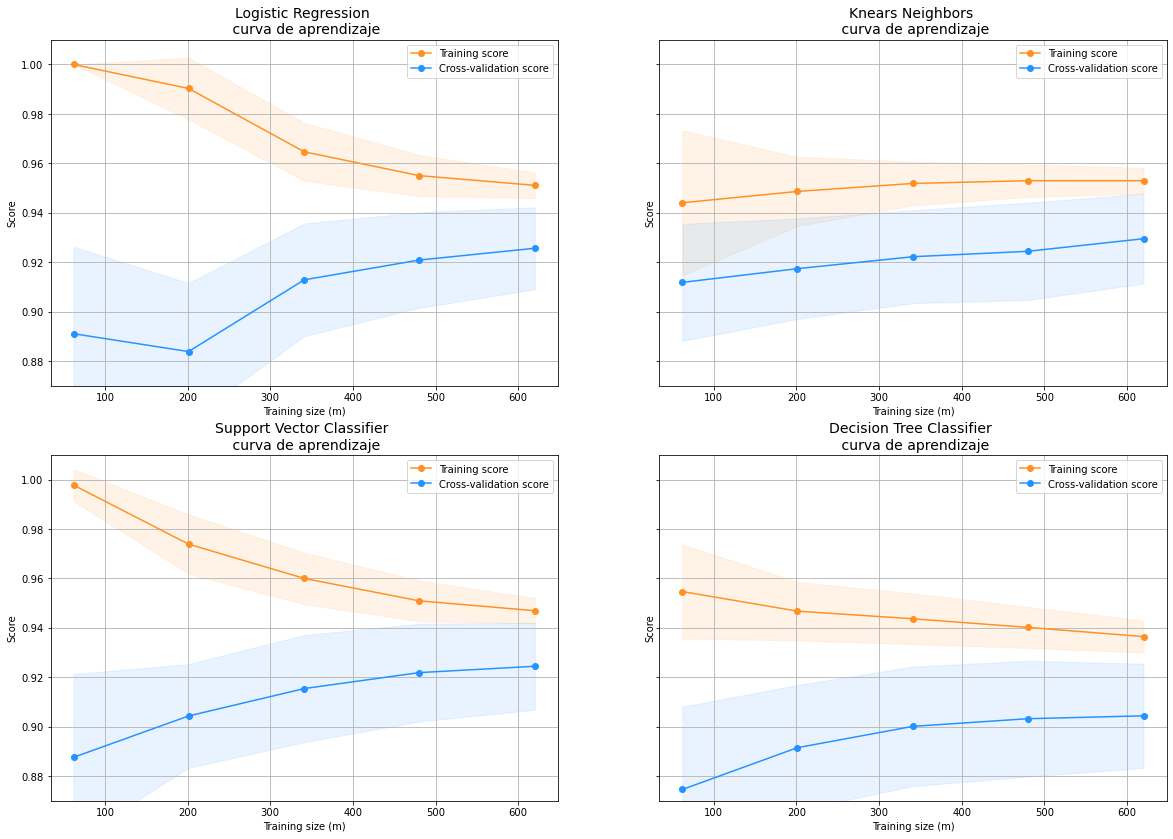

In [29]:
# Se grafican las curvas de aprendizaje para determinar si hubo overfitting o underfitting


def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression \n curva de aprendizaje", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors \n curva de aprendizaje", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n curva de aprendizaje", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n curva de aprendizaje", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(RUS_log_reg, RUS_knears_neighbors, RUS_svc, RUS_tree_clf, RUS_X_train, RUS_y_train, (0.87, 1.01), cv=cv, n_jobs=4)

Los ajustes son buenos en lineas generales, ya que no se observa una diferencia elevada entre los score de entrenamiento y validacion (overfitting) ni score cercanos y bajos (underfitting).

In [30]:
RUS_log_reg_pred = cross_val_predict(RUS_log_reg, RUS_X_train, RUS_y_train, cv=5,
                             method="decision_function")

RUS_knears_pred = cross_val_predict(RUS_knears_neighbors, RUS_X_train, RUS_y_train, cv=5)

RUS_svc_pred = cross_val_predict(RUS_svc, RUS_X_train, RUS_y_train, cv=5,
                             method="decision_function")

RUS_tree_pred = cross_val_predict(RUS_tree_clf, RUS_X_train, RUS_y_train, cv=5)



print('Logistic Regression: ', roc_auc_score(RUS_y_train, RUS_log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(RUS_y_train, RUS_knears_pred))
print('Support Vector Classifier: ', roc_auc_score(RUS_y_train, RUS_svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(RUS_y_train, RUS_tree_pred))

Logistic Regression:  0.9764666666666667
KNears Neighbors:  0.93425
Support Vector Classifier:  0.96946
Decision Tree Classifier:  0.9124999999999999


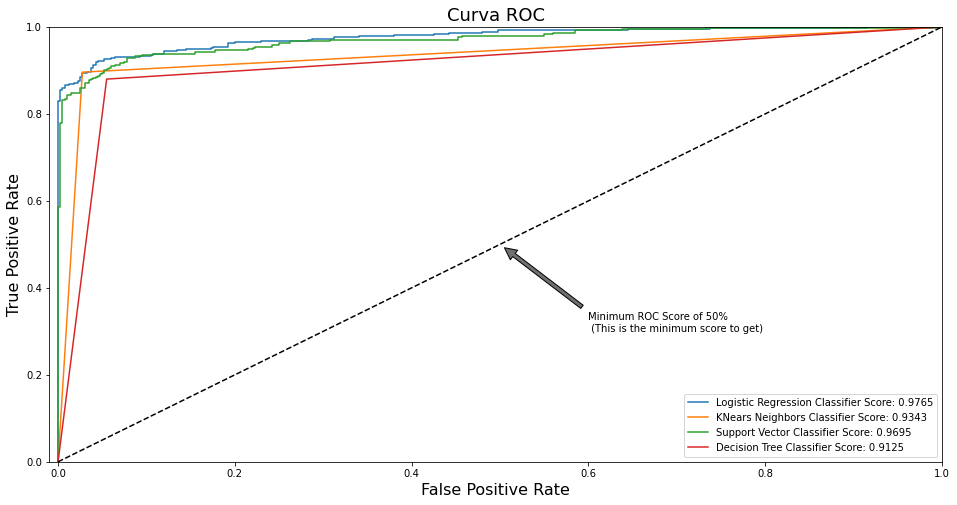

In [31]:
# Se grafica la curva ROC para todos los casos

log_fpr, log_tpr, log_thresold = roc_curve(RUS_y_train, RUS_log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(RUS_y_train, RUS_knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(RUS_y_train, RUS_svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(RUS_y_train, RUS_tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('Curva ROC', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(RUS_y_train, RUS_log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(RUS_y_train, RUS_knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(RUS_y_train, RUS_svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(RUS_y_train, RUS_tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

En resumen, el clasificador de regresión logística es más preciso que los otros tres clasificadores en la mayoría de los casos. Con GridSearchCV se determinaron los parámetros que dan la mejor puntuación predictiva para los clasificadores. La regresión logística tiene la mejor puntuación de característica operativa de recepción (ROC), lo que implica que separa con precisión las transacciones fraudulentas y no fraudulentas.

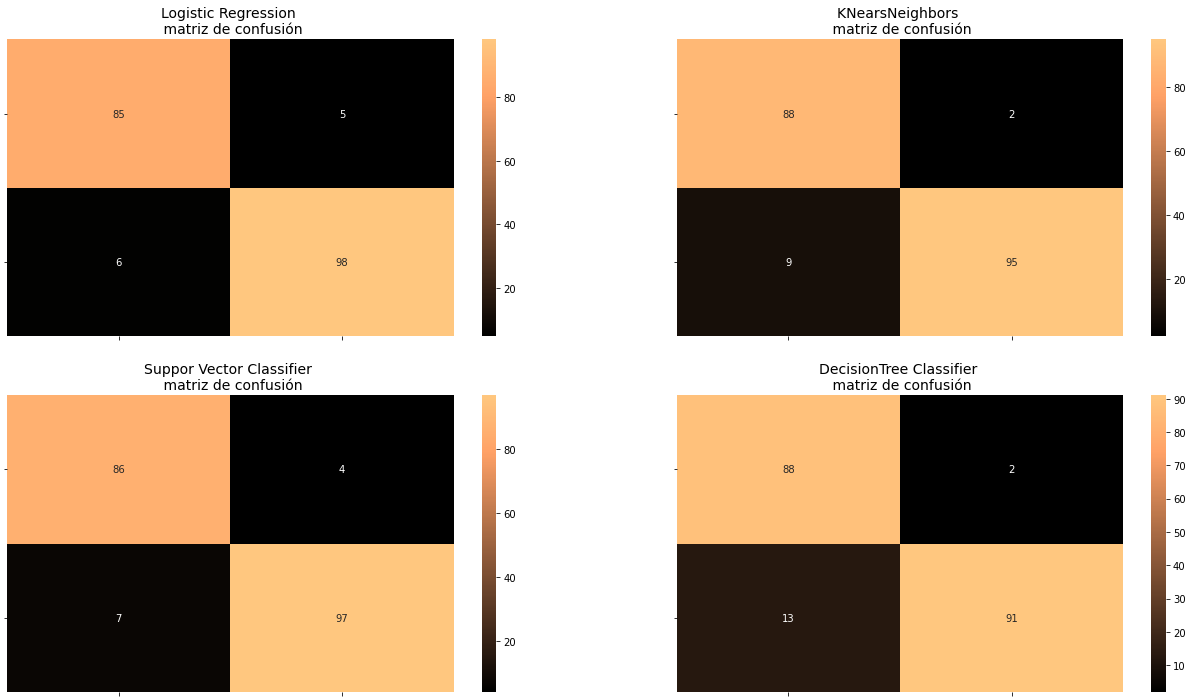

In [32]:
#Se grafican las matrices de confusion

from sklearn.metrics import confusion_matrix

RUS_y_pred_log_reg = RUS_log_reg.predict(RUS_X_test)
RUS_y_pred_knear = RUS_knears_neighbors.predict(RUS_X_test)
RUS_y_pred_svc = RUS_svc.predict(RUS_X_test)
RUS_y_pred_tree = RUS_tree_clf.predict(RUS_X_test)


RUS_log_reg_cf = confusion_matrix(RUS_y_test, RUS_y_pred_log_reg)
RUS_kneighbors_cf = confusion_matrix(RUS_y_test, RUS_y_pred_knear)
RUS_svc_cf = confusion_matrix(RUS_y_test, RUS_y_pred_svc)
RUS_tree_cf = confusion_matrix(RUS_y_test, RUS_y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(RUS_log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n matriz de confusión", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(RUS_kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n matriz de confusión", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(RUS_svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n matriz de confusión", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(RUS_tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n matriz de confusión", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

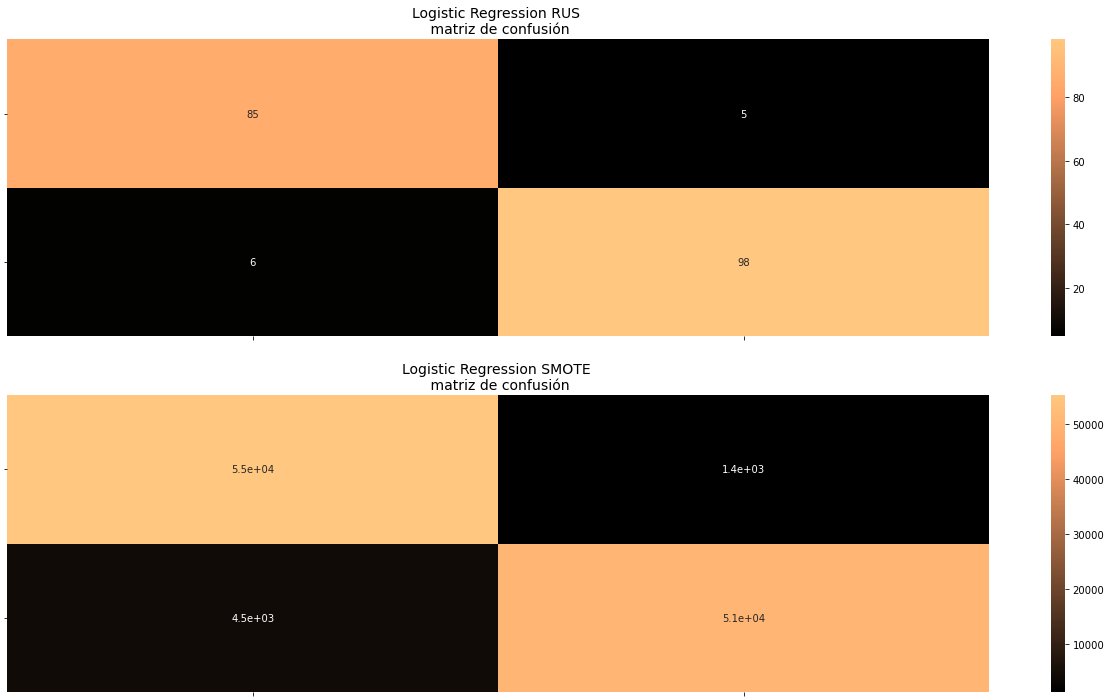

In [33]:
#Se grafican las matrices de confusion

from sklearn.metrics import confusion_matrix

RUS_y_pred_log_reg = RUS_log_reg.predict(RUS_X_test)
SM_y_pred_log_reg = SM_log_reg.predict(SM_X_test)

RUS_log_reg_cf = confusion_matrix(RUS_y_test, RUS_y_pred_log_reg)
SM_log_reg_cf = confusion_matrix(SM_y_test, SM_y_pred_log_reg)

fig, ax = plt.subplots(2, 1,figsize=(22,12))


sns.heatmap(RUS_log_reg_cf, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Logistic Regression RUS \n matriz de confusión", fontsize=14)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(SM_log_reg_cf, ax=ax[1], annot=True, cmap=plt.cm.copper)
ax[1].set_title("Logistic Regression SMOTE \n matriz de confusión", fontsize=14)
ax[1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [34]:
#Se compara  el score de la regresion logistica con distribuciones RUS y SMOTE

RUS_y_pred = RUS_log_reg.predict(RUS_X_test)
RUS_score = accuracy_score(RUS_y_test, RUS_y_pred)

SM_y_pred = SM_log_reg.predict(SM_X_test)
SM_score = accuracy_score(SM_y_test, SM_y_pred)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [RUS_score, SM_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.943299
1,Oversampling (SMOTE),0.947602


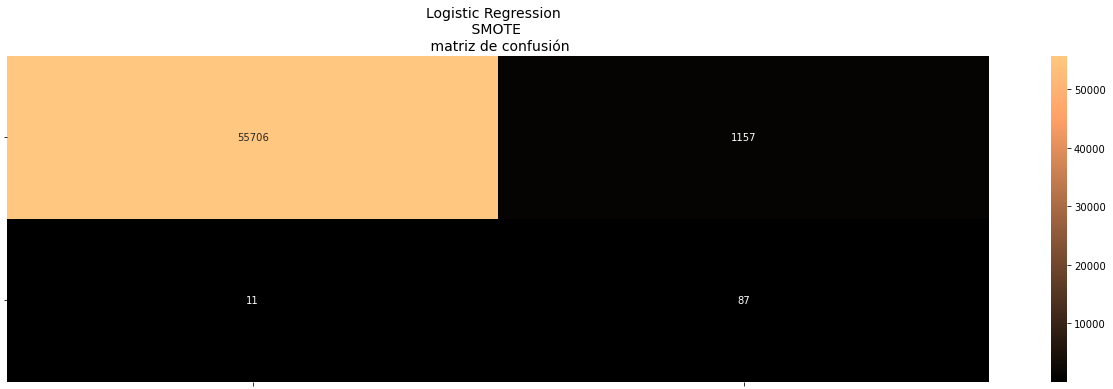

In [35]:
#Se testeo el algoritmos de regresion logitica SMOTE con los datos orginales

SM_original_Xtest = original_Xtest  
SM_original_ytest = original_ytest

SM_y_pred_log_reg_test = SM_log_reg.predict(SM_original_Xtest)

SM_log_reg_cf = confusion_matrix(SM_original_ytest, SM_y_pred_log_reg_test)

fig, ax = plt.subplots(1, 1,figsize=(22,6))


sns.heatmap(SM_log_reg_cf, ax=ax, annot=True, cmap=plt.cm.copper, fmt='g')
ax.set_title("Logistic Regression  \n SMOTE  \n matriz de confusión", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

El modelo no puede detectar correctamente en una gran cantidad de casos las transacciones que no son fraudulentas y, en cambio, clasifica erróneamente esas transacciones que no son fraudulentas como casos de fraude. Esto genera que algunas de las personas que estaban haciendo compras regulares se les bloquee la tarjeta debido a que el modelo clasificó esa transacción como una transacción fraudulenta, esto será una gran desventaja. El siguiente paso de este análisis podria ser disminuir la precision para aumentar el numero de transaciones fraudulentas detectadas o no fraudulentas detectadas, segun sea requerido (precsion/recall tradeoff) o buscar otro algoritmo que brinde mejores resultados (RandomForest o Gradient Descent).